In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

In [ ]:
dataset = nlp.load_dataset("emotion")

In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset["train"]
test = dataset["test"]
valid = dataset["validation"]

In [ ]:
def get_tweet(data):
  tweets = [x["text"] for x in data]
  labels = [x["label"] for x in data]
  return tweets, labels

In [ ]:
tweets , labels = get_tweet(train)

In [ ]:
for i in range(5):
  print(tweets[i])
  print(labels[i])

i didnt feel humiliated
sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
sadness
im grabbing a minute to post i feel greedy wrong
anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
love
i am feeling grouchy
anger


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tokenizer = Tokenizer(num_words = 10000 , oov_token = "<UNK>")
tokenizer.fit_on_texts(tweets)

In [ ]:
tweets[0]

'i didnt feel humiliated'

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

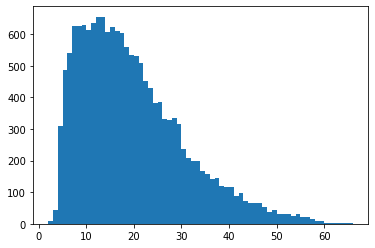

In [ ]:
lengths = [len(t.split(" ")) for t in tweets ]
plt.hist(lengths , bins=(len(set(lengths))))
plt.show()

In [ ]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer , tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences , truncating = "post" , padding = "post" , maxlen = maxlen)
  return padded


In [ ]:
padded_train_sequences = get_sequences(tokenizer , tweets)
# padded_train_sequences = X = np.asarray(padded_train_sequences).astype(np.float32)

In [ ]:
classes = set(labels)

In [ ]:
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [ ]:
class_to_index = dict((c, k) for c , k in enumerate(classes))
index_to_class = dict((v, k) for k ,v in class_to_index.items())

In [ ]:
class_to_index

{0: 'surprise', 1: 'anger', 2: 'fear', 3: 'sadness', 4: 'joy', 5: 'love'}

In [ ]:
index_to_class

{'surprise': 0, 'anger': 1, 'fear': 2, 'sadness': 3, 'joy': 4, 'love': 5}

In [ ]:
names_to_ids = lambda labels: np.array([index_to_class.get(x) for x in labels])

# def names_to_ids(labels):
#   for x in labels :
#     name_to_ids =  np.array([class_to_index.get(x)])
#   return name_to_ids

In [ ]:
train_labels = names_to_ids(labels)

In [ ]:
print(train_labels[0])

3


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16 , input_length = maxlen) ,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20 , return_sequences=True)) ,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation ="softmax")
])

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam" , 
    metrics = ["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_tweets , val_labels = get_tweet(valid)

val_seq = get_sequences(tokenizer , val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0]

'im feeling quite sad and sorry for myself but ill snap out of it soon'

In [ ]:
h = model.fit(
    padded_train_sequences , train_labels ,
    validation_data = (val_seq , val_labels),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor ="val_accuracy" , patience = 2)],
    epochs =20
)

Epoch 1/20
500/500 [==============================] - 18s 24ms/step - loss: 1.3761 - accuracy: 0.4533 - val_loss: 1.0141 - val_accuracy: 0.5935
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.6562 - accuracy: 0.7664 - val_loss: 0.4901 - val_accuracy: 0.8500
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2773 - accuracy: 0.9129 - val_loss: 0.3664 - val_accuracy: 0.8865
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1649 - accuracy: 0.9486 - val_loss: 0.3559 - val_accuracy: 0.8945
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1149 - accuracy: 0.9652 - val_loss: 0.3534 - val_accuracy: 0.8920
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.0939 - accuracy: 0.9711 - val_loss: 0.3425 - val_accuracy: 0.8985
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.0815 - accuracy: 0.9740 - val_loss: 0.3301 - val_accuracy: 0.898

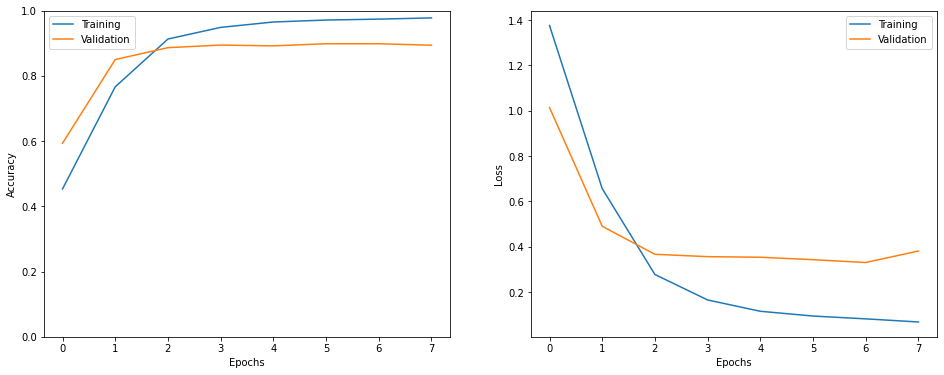

In [ ]:
show_history(h)

In [ ]:
test_data , test_label = get_tweet(test)
test_seq = get_sequences(tokenizer , test_data)
test_labels = names_to_ids(test_label)

In [ ]:
model.evaluate(test_seq , test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4292 - accuracy: 0.8840


[0.4292457103729248, 0.8840000033378601]

In [ ]:
type(test_data[0])

str

In [ ]:
i = random.randint(0,len(test_label)-1)
print("sentence: " , test_data[i])
print("label :" , labels[i])


p = model.predict(np.expand_dims(test_seq[i] , axis=0))[0]
pred_class = class_to_index[np.argmax(p).astype('uint8')]

print("predicted emotion :" , pred_class)


sentence:  ive been getting have been making me feel suspicious like its someone elses great work they are trying to get credit for
label : joy
1/1 [==============================] - 1s 1s/step
predicted emotion : fear


In [ ]:
print(test_seq[0])

[  17    8  203  715   15   17   26   46 5595  114   58    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
def customize(array):
  cust_seq = get_sequences(tokenizer , array)
  return cust_seq 


In [ ]:
examples = ["today i saw a ghost while walking down a street and a creepy man followed me which made me very scared for my life" , "today i met a girl and she was very cute and she said she liked me"]

my_set =  customize(examples)

In [ ]:
p = model.predict(np.expand_dims(my_set[0] , axis=0))[0]
pred_class = class_to_index[np.argmax(p).astype('uint8')]

print("predicted emotion :" , pred_class)

1/1 [==============================] - 0s 20ms/step
predicted emotion : fear
